In [1]:
import matplotlib.pyplot as pl
import numpy as np
from scipy.interpolate import griddata
import scipy.spatial as spat
import os
from matplotlib.lines import Line2D
from scipy.interpolate import interp1d
import matplotlib.ticker as mticker
pl.rcParams.update({'font.size':20})
#pl.rcParams['agg.path.chunksize'] = 1000000

from matplotlib.colors import LogNorm
from scipy.signal import savgol_filter
import scipy.stats as scist

In [2]:
router=500.

l0=69599000000.000000
m0=1.9891000000000000E+033
t0=1.8445e-02*86400
p0=11253326797072562.
d0=m0/(l0*l0*l0)
G=6.67259e-8
kb=1.380658e-16
arad=7.5646e-15

In [3]:
# Path where the ascii files of the snapshots are located.
data_path = '/home/juanmanuel/Documents/Master/Thesis/Simulations/'
data_path_re = '/home/juanmanuel/Documents/Master/Thesis/Simulations/Relaxation'

In [4]:
lrtab1,mtab1,htab1,hetab1,lTtab1,lPtab1 = np.genfromtxt('{}MESA/star2_MESA'.format(data_path),
                                                        dtype='float', usecols=(2,1,6,7,3,5), skip_header=6,
                                                        comments="#", unpack=True)

In [5]:
tens1=lrtab1*0.+10.

rtab1=np.power(tens1,lrtab1)
Ttab1=np.power(tens1,lTtab1)
Ptab1=np.power(tens1,lPtab1)

rtab1=np.flip(rtab1)
htab1=np.flip(htab1)
hetab1=np.flip(hetab1)

mtab1=np.flip(mtab1)

Ttab1=np.flip(Ttab1)
lTtab1=np.flip(lTtab1)

Ptab1=np.flip(Ptab1)
lPtab1=np.flip(lPtab1)

#For the primary stars
#rcore=np.amax(rtab1[hetab1>0.95])

#Only for MESA TAMS
#rcore=np.amax(rtab1[hetab1>0.5])

#For the secondary stars
#rcore=np.amax(rtab1[htab1<0.6])

#Only for MESA ZAMS
rcore=2.5
mcore=mtab1[len(rtab1[rtab1<rcore])-1]
print(rcore,mcore)

2.5 12.732670216915796


In [6]:
rinn=rtab1[rtab1<rcore]
Pinn=Ptab1[rtab1<rcore]
Tinn=Ttab1[rtab1<rcore]
minn=mtab1[rtab1<rcore]
hinn=htab1[rtab1<rcore]
heinn=hetab1[rtab1<rcore]

drout=(100.-rcore)/1300.

rout1=np.linspace(rcore,3.95,20)
rout2=np.logspace(np.log10(3.96),np.log10(6./5.*router),100)
rout=np.concatenate((rout1,rout2),axis=None)

rinterp=np.logspace(np.log10(rcore),np.log10(router),400)
tensint=rinterp*0.+10.

dtab1=mtab1*0.

for i in np.arange(len(rtab1)):
    if(i==0):
        mloc=mtab1[i]
        vloc=4./3.*np.pi*rtab1[i]*rtab1[i]*rtab1[i]
    else:
        mloc=mtab1[i]-mtab1[i-1]
        vloc=4./3.*np.pi*(rtab1[i]*rtab1[i]*rtab1[i]-rtab1[i-1]*rtab1[i-1]*rtab1[i-1])
    dtab1[i]=mloc/vloc

In [7]:
dtab1=dtab1*d0

indz1=np.argmin(dtab1)
dtab1=np.delete(dtab1,indz1)
rtab1=np.delete(rtab1,indz1)
htab1=np.delete(htab1,indz1)
mtab1=np.delete(mtab1,indz1)
hetab1=np.delete(hetab1,indz1)

dinn=dtab1[rtab1<rcore]
denafter=dtab1[len(rtab1[rtab1<rcore])+1]

In [8]:
#Only for MESA 40 ZAMS
l=40

#l=300
lstr='{:04d}'.format(l)
print(lstr)
time='{:.1f}'.format(l/2.*1.8445e-02)
x,y,z,vx,vy,vz,m,d,inten,t = np.genfromtxt("{}/mod12_40ZAMS/out".format(data_path_re)+lstr+'.sph.ascii',
                                            dtype="float", usecols=(0,1,2,3,4,5,6,7,8,12),
                                            skip_header=12,comments="#", unpack=True)

0040


In [9]:
#artificially scaling
indexpart=np.arange(len(x))
d=d*d0
t=t/4.

#to be adapted to the number of particles in the primary + 1
#x1=x[0:799021]
#y1=y[0:799021]
#z1=z[0:799021]
#m1=m[0:799021]
#d1=d[0:799021]

#to be adapted to the number of particles in the secondary + 1
x1=x[0:90001]
y1=y[0:90001]
z1=z[0:90001]
m1=m[0:90001]
d1=d[0:90001]

p=2./3.*(d/d0)*inten*p0

In [10]:
h,he = np.genfromtxt("{}/mod12_40ZAMS/init_ab_frac1.dat".format(data_path_re),
                        dtype="float", usecols=(0,1) ,skip_header=1,comments="#", unpack=True)

In [11]:
#find the center of mass of all the particles that are more massive than 0.1 Msun

xcm = x[np.argmax(d)]
ycm = y[np.argmax(d)]
zcm = z[np.argmax(d)]

vxcm = vx[np.argmax(d)]
vycm = vy[np.argmax(d)]
vzcm = vz[np.argmax(d)]
    
r=np.sqrt((x-xcm)*(x-xcm)+(y-ycm)*(y-ycm)+(z-zcm)*(z-zcm))

#r1=r[0:799021]

r1=r[0:90001]

xnew=x-xcm
ynew=y-ycm
znew=z-zcm
vxnew=vx-vxcm
vynew=vy-vzcm
vznew=vz-vzcm

flag=np.zeros(len(r1))

isbound=np.argsort(r)
    
xnew=vxnew[isbound]
ynew=vynew[isbound]
znew=vznew[isbound]

vxnew=vxnew[isbound]
vynew=vynew[isbound]
vznew=vznew[isbound]

r=r[isbound]
d=d[isbound]
inten=inten[isbound]
p=p[isbound]
t=t[isbound]
h=h[isbound]
he=he[isbound]
m=m[isbound]


flag=flag[isbound]
v2=(vxnew)*(vxnew)+(vynew)*(vynew)+(vznew)*(vznew)
mintern=np.cumsum(m)

In [12]:
np.place(mintern,mintern<=mcore,mcore)
en=0.5*v2*l0*l0/t0/t0+inten*p0/d0-G*mintern*m0/(r*l0)
bound=np.where(en<0.)[0]

xnew=xnew[bound]
ynew=ynew[bound]
znew=znew[bound]
vxnew=vxnew[bound]
vynew=vynew[bound]
vznew=vznew[bound]
r=r[bound]

m=m[bound]
d=d[bound]
inten=inten[bound]
p=p[bound]
t=t[bound]
h=h[bound]
he=he[bound]
flag=flag[bound]

print('max r', np.amax(r))
print('mbound',np.sum(m))

max r 11.69171823976607
mbound 39.99891447781107


/tmp/ipykernel_8217/1653112337.py:2: RuntimeWarning: divide by zero encountered in true_divide
  en=0.5*v2*l0*l0/t0/t0+inten*p0/d0-G*mintern*m0/(r*l0)


In [13]:
mcpartbou=[]
mrbou=0.
rbou=r
mbou=m
mbousort=[x for _,x in sorted(zip(rbou,mbou))]
rbousort=[x for _,x in sorted(zip(rbou,rbou))]
    
for i in np.arange(len(mbousort)):
    mrbou=mrbou+mbousort[i]
    mcpartbou.append(mrbou)

In [14]:
mcpartbou=np.array(mcpartbou)

rlast=r[r>rcore]
mlast=m[r>rcore]
hlast=h[r>rcore]
helast=he[r>rcore]
flaglast=flag[r>rcore]
dlast=d[r>rcore]
intenlast=inten[r>rcore]
tlast=t[r>rcore]

denref=rout*0.
denbin=denref[0:-1]
Pbin=denbin*0.
Tbin=denbin*0.
mcumbin=denbin*0.

dencut=[]
cmasscut=[]
Tcut=[]
Pcut=[]
hcut=[]
hecut=[]

print('mcore, diciamo... ',np.sum(m[r<=rcore]))
print('check abund envelope')
print('menv = ', np.sum(mlast))
print('mHeenv = ', np.sum(mlast*helast))
print('mHecore = ', np.sum(m[r<=rcore]*he[r<=rcore]))
print('mHenv = ', np.sum(mlast*hlast))
print('mHcore = ', np.sum(m[r<=rcore]*h[r<=rcore]))
print('fHetot = ',np.sum(mlast*helast)/np.sum(mlast))
print('fHtot = ',np.sum(mlast*hlast)/np.sum(mlast))

mcore, diciamo...  12.562906729997906
check abund envelope
menv =  27.436007747813157
mHeenv =  6.694385481806381
mHecore =  3.0653280961191385
mHenv =  20.686749424978952
mHcore =  9.47232034109879
fHetot =  0.2439999851049747
fHtot =  0.753999984805655


In [15]:
mtotal=np.sum(m[r<=rcore])
for i in np.arange(1,len(rout)):
    
    indsum=((rlast<=rout[i]) & (rlast>rout[i-1]))
    mbin=np.sum(mlast[indsum])
    
    volbin=4./3.*np.pi*(rout[i]*rout[i]*rout[i]-rout[i-1]*rout[i-1]*rout[i-1])
    denbin[i-1]=mbin/volbin*d0
    intenbin=np.sum(dlast[indsum]*intenlast[indsum])/np.sum(dlast[indsum])
    Pbin[i-1]=2./3.*mbin/volbin*intenbin*p0
    Tbin[i-1]=np.sum(dlast[indsum]*tlast[indsum])/np.sum(dlast[indsum])
    
    mtotal=mtotal+mbin
    mcumbin[i-1]=mtotal
    
    denbinint=interp1d(rout[0:-1],np.log10(denbin),kind='linear')
    mcumbinint=interp1d(rout[0:-1],mcumbin,kind='linear')
    Tbinint=interp1d(rout[0:-1],np.log10(Tbin),kind='linear')
    Pbinint=interp1d(rout[0:-1],np.log10(Pbin),kind='linear')
    
    denbininterp=np.power(tensint,denbinint(rinterp))
    mcumbininterp=mcumbinint(rinterp)
    Tbininterp=np.power(tensint,Tbinint(rinterp))
    Pbininterp=np.power(tensint,Pbinint(rinterp))

/tmp/ipykernel_8217/779941636.py:16: RuntimeWarning: divide by zero encountered in log10
  denbinint=interp1d(rout[0:-1],np.log10(denbin),kind='linear')
/tmp/ipykernel_8217/779941636.py:18: RuntimeWarning: divide by zero encountered in log10
  Tbinint=interp1d(rout[0:-1],np.log10(Tbin),kind='linear')
/tmp/ipykernel_8217/779941636.py:19: RuntimeWarning: divide by zero encountered in log10
  Pbinint=interp1d(rout[0:-1],np.log10(Pbin),kind='linear')
/tmp/ipykernel_8217/779941636.py:9: RuntimeWarning: invalid value encountered in double_scalars
  intenbin=np.sum(dlast[indsum]*intenlast[indsum])/np.sum(dlast[indsum])
/tmp/ipykernel_8217/779941636.py:11: RuntimeWarning: invalid value encountered in double_scalars
  Tbin[i-1]=np.sum(dlast[indsum]*tlast[indsum])/np.sum(dlast[indsum])


In [16]:
kernel_size=20
kernel=np.ones(kernel_size)/kernel_size

dav=np.concatenate((dinn,denbininterp),axis=None)
Pav=np.concatenate((Pinn,Pbininterp),axis=None)
Tav=np.concatenate((Tinn,Tbininterp),axis=None)
mcumav=np.concatenate((minn,mcumbininterp),axis=None)

rav=np.concatenate((rinn,rinterp),axis=None)

dav2=np.convolve(dav,kernel,mode='same')
Pav2=np.convolve(Pav,kernel,mode='same')
Tav2=np.convolve(Tav,kernel,mode='same')
mcumav2=np.convolve(mcumav,kernel,mode='same')

indstart=np.argmin(np.abs(rav-5.e-2))
indend=np.argmin(np.abs(rav-1.e2))

dav=np.concatenate((dav[0:indstart],dav2[indstart:indend],dav[indend:]),axis=None)
Pav=np.concatenate((Pav[0:indstart],Pav2[indstart:indend],Pav[indend:]),axis=None)
Tav=np.concatenate((Tav[0:indstart],Tav2[indstart:indend],Tav[indend:]),axis=None)
mcumav=np.concatenate((mcumav[0:indstart],mcumav2[indstart:indend],mcumav[indend:]),axis=None)

In [17]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

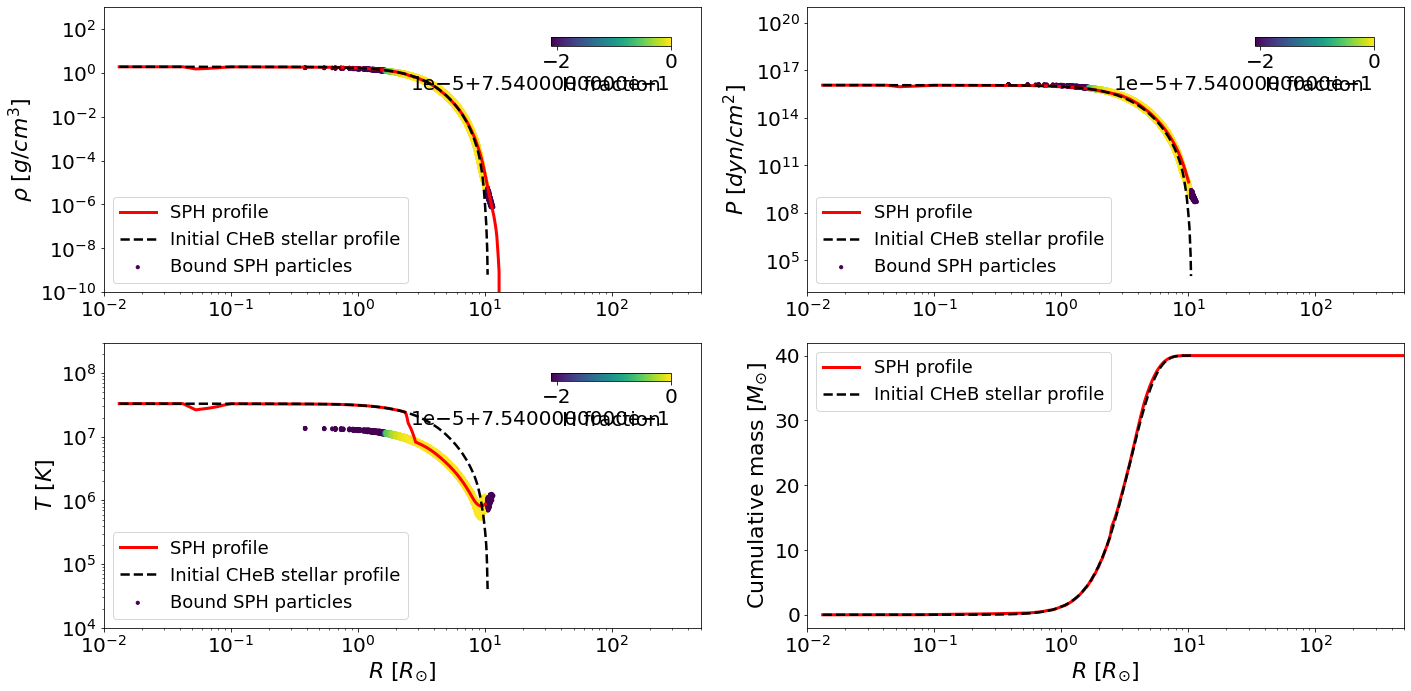

In [18]:
fig, axs=pl.subplots(nrows=2,  ncols=2, figsize=(20,10))
fig.subplots_adjust(hspace=0.3)

#cm = pl.cm.get_cmap('RdYlBu_r')
cm = pl.cm.get_cmap('viridis')

axs[0,0].plot(rav,dav,'r',linewidth=3, label='SPH profile')
axs[0,0].plot(rtab1,dtab1,'--k',linewidth=2.5,label='Initial CHeB stellar profile')
pcm=axs[0,0].scatter(r,d,s=10,c=h,cmap=cm, label='Bound SPH particles')
#axs[0,0].scatter(r,d,s=1,c='grey', label='bound SPH particles')
axs[0,0].set_ylabel(r'$\rho$ [$g/cm^3$]', fontsize = 22)
axs[0,0].legend(fontsize = 18, loc=0)
axs[0,0].set_ylim(1.e-10,1000.)
axs[0,0].set_xlim(1.e-2,500.)
#axs[0,0].set_ylim(1.e-10,500.)
#axs[0,0].set_xlim(4.e-2,20.)
axs[0,0].set_yscale('log')
axs[0,0].set_xscale('log')

axs[0,1].plot(rav,Pav,'r',linewidth=3, label='SPH profile' )
axs[0,1].plot(rtab1,Ptab1[0:-1],'--k',linewidth=2.5,label='Initial CHeB stellar profile')
pcm2=axs[0,1].scatter(r,p,s=10,c=h,cmap=cm, label='Bound SPH particles')
#axs[0,1].scatter(r,p,s=1,c='k', label='bound SPH particles, 10 days')
axs[0,1].legend(fontsize = 18, loc=0)
axs[0,1].set_xscale('log')
axs[0,1].set_yscale('log')
axs[0,1].set_xlim(1.e-2,500.)
axs[0,1].set_ylim(1.e3,1.e21)
#axs[0,1].set_xlim(4.e-2,20.)
axs[0,1].set_ylabel(r'$P$ [$dyn/cm^2$]',fontsize=22)

axs[1,0].plot(rav,Tav,'r',linewidth=3, label='SPH profile')
axs[1,0].plot(rtab1,Ttab1[0:-1],'--k',linewidth=2.5,label='Initial CHeB stellar profile')
pcm3=axs[1,0].scatter(r,t,s=10,c=h,cmap=cm, label='Bound SPH particles')
#axs[1,0].scatter(r,t,s=1,c='k', label='bound SPH particles, 10 days')
axs[1,0].legend(fontsize = 18, loc=0)
axs[1,0].set_xscale('log')
axs[1,0].set_yscale('log')
axs[1,0].set_xlim(1.e-2,500.)
axs[1,0].set_ylim(1.e4,3.e8)
#axs[1,0].set_xlim(4.e-2,20.)
axs[1,0].set_ylabel(r'$T$ [$K$]',fontsize=22)
axs[1,0].set_xlabel('$R$ [$R_{\odot}}$]',fontsize=22)

axs[1,1].plot(rav,mcumav,'r',linewidth=3, label='SPH profile')
axs[1,1].plot(rtab1,mtab1,'--k',linewidth=2.5,label='Initial CHeB stellar profile')
#axs[1,1].scatter(r,np.cumsum(m),s=1,c='k', label='bound SPH particles, 10 days')
axs[1,1].legend(fontsize = 18, loc=0)
axs[1,1].set_xscale('log')
axs[1,1].set_xlim(1.e-2,500.)
#axs[1,1].set_xlim(4.e-2,20.)
axs[1,1].set_ylabel(r'Cumulative mass [$M_{\odot}}$]',fontsize=22)
axs[1,1].set_xlabel('$R$ [$R_{\odot}}$]',fontsize=22)

fig.tight_layout()

cbaxes = inset_axes(axs[0,0], width="20%", height="3%", loc='upper right', borderpad=1.5)
cbaxes2 = inset_axes(axs[0,1], width="20%", height="3%", loc='upper right', borderpad=1.5) 
cbaxes3 = inset_axes(axs[1,0], width="20%", height="3%", loc='upper right', borderpad=1.5) 

pl.colorbar(pcm, cax=cbaxes, label=r'H fraction', orientation='horizontal')
pl.colorbar(pcm2, cax=cbaxes2, label=r'H fraction', orientation='horizontal')
pl.colorbar(pcm3, cax=cbaxes3, label=r'H fraction', orientation='horizontal')

pl.show()

In [20]:
np.unique(h)

array([0.75397898, 0.75397898, 0.75397898, 0.75397898, 0.75397898,
       0.75397898, 0.75397898, 0.75397898, 0.75397898, 0.75397898,
       0.75397898, 0.75397898, 0.75397898, 0.75397898, 0.75397898,
       0.75397898, 0.75397898, 0.75397898, 0.75397898, 0.75397898,
       0.75397898, 0.75397898, 0.75397898, 0.75397898, 0.75397898,
       0.75397898, 0.75397898, 0.75397898, 0.75397898, 0.75397898,
       0.7539863 , 0.75399396, 0.75399443, 0.75399486, 0.7539954 ,
       0.75399588, 0.7539961 , 0.75399642, 0.75399671, 0.75399706,
       0.75399737, 0.75399759, 0.75399785, 0.75399813, 0.75399834,
       0.75399847, 0.75399868, 0.75399882, 0.75399901, 0.75399917,
       0.75399922, 0.75399928, 0.75399936, 0.75399942, 0.75399945,
       0.75399949, 0.75399954, 0.75399959, 0.75399963, 0.75399967,
       0.75399971, 0.75399973, 0.75399976, 0.75399977, 0.75399979,
       0.75399981, 0.75399982, 0.75399984, 0.75399985, 0.75399986,
       0.75399987, 0.75399988, 0.75399989, 0.7539999 , 0.75399